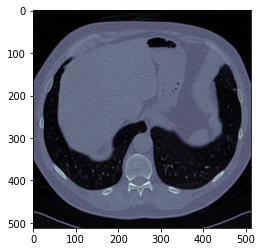

In [6]:
########################################################################################
# Part 1-1: Read in and print out all the data fields in a DICOM file (one slice) (5%) #
#     In this part, we go through every folders to get the image and print it out.     #
#      It will only show one image. If you want to see more, please comment break      #
########################################################################################

import numpy as np
import pydicom
import matplotlib.pyplot as plt
import os

datadir = './CT_chest_scans'
folders = os.listdir(datadir)
for folder in folders:
    imagedir = os.path.join(datadir, folder)
    images = os.listdir(imagedir)
    for image in images:
        image_path = os.path.join(imagedir, image)
        pic = pydicom.dcmread(image_path)
        plt.imshow(pic.pixel_array, cmap=plt.cm.bone)
        plt.show()
        break # comment this if you want to see more plots
    break # comment this if you want to see more plots

In [7]:
#########################################################################################################
# Part 1-2: Read in the raw data for a CT slice and convert its pixel values into Hounsfield units.     #
# Compute the max, min, mean and standard deviation of both images (raw data and Hounsfield units) (5%) #
#    In this part, we convert pixel value of the CT image into Hounsfield units using this equation     #
#                Hounsfield units = (Rescale Slope * Pixel Value) + Rescale Intercept                   #
#########################################################################################################

import numpy as np
import pydicom
import matplotlib.pyplot as plt
import os

datadir = './CT_chest_scans'
ct_pixel = []
ct_hounsfield = []
folders = os.listdir(datadir)
for folder in folders:
    imagedir = os.path.join(datadir, folder)
    images = os.listdir(imagedir)
    for image in images:
        image_path = os.path.join(imagedir, image)
        pic = pydicom.dcmread(image_path)
        pixel_value = np.clip(pic.pixel_array, 0, 255)
        ct_pixel.append(pixel_value)
        rescale_intercept = pic[0x0028, 0x1052].value
        rescale_slope = pic[0x0028, 0x1053].value
        hounsfield_units = (rescale_slope * pixel_value) + rescale_intercept
        ct_hounsfield.append(hounsfield_units)
print("Maximum of raw data pixels =", np.amax(ct_pixel))
print("Minimum of raw data pixels =", np.amin(ct_pixel))
print("Mean of raw data pixels =", np.mean(ct_pixel))
print("Standard deviation of raw data pixels =", np.std(ct_pixel))
print("Maximum of Hounsfield units =", np.amax(ct_hounsfield))
print("Minimum of Hounsfield units =", np.amin(ct_hounsfield))
print("Mean of Hounsfield units =", np.mean(ct_hounsfield))
print("Standard deviation of Hounsfield units =", np.std(ct_hounsfield))

Maximum of raw data pixels = 255
Minimum of raw data pixels = 0
Mean of raw data pixels = 144.06127640303973
Standard deviation of raw data pixels = 111.19294218773159
Maximum of Hounsfield units = 255.0
Minimum of Hounsfield units = -1024.0
Mean of Hounsfield units = -817.1462707667716
Standard deviation of Hounsfield units = 240.6105942529713


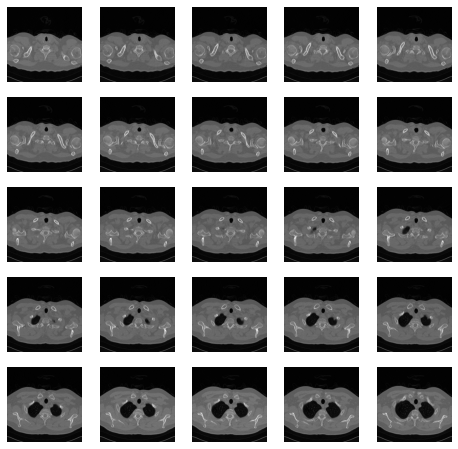

In [5]:
#########################################################################################################################################
# Part 2: Now we want to read in a 3D volume. (DICOM files in a folder)                                                               #
# Note that you will need to sort all the slices to make it into correct order. Please explain how do you sort the slices. (10%)        #
# Normalize all the pixel from Hounsfield Units to float32 type number between 0.0 to 1.0 and display 25 slices in correct order. (10%) #
#########################################################################################################################################
'''
I get the pixel value of the picture and instance number at the same time, then make them into a dictionary. 
Use instance number as key, pixel value as pair, so that I can sort the key value pairs with orders.
'''

import numpy as np
import pydicom
import matplotlib.pyplot as plt
import os

def get_hu(pic): # convert the pixel value into hounsfield units
    pixel_value = np.clip(pic.pixel_array, 0, 255)
    rescale_intercept = pic[0x0028, 0x1052].value
    rescale_slope = pic[0x0028, 0x1053].value
    hounsfield_units = (rescale_slope * pixel_value) + rescale_intercept
    nor_hu = normalize_hu(hounsfield_units)

    return nor_hu

def normalize_hu(hounsfield_units): # normalize the hounsfield units
    nor_hu = np.array([(x+1024) / 4096 for x in hounsfield_units])

    return np.float32(nor_hu)

datadir = './CT_chest_scans'

folders = os.listdir(datadir)
for folder in folders:
    imagedir = os.path.join(datadir, folder)
    images = os.listdir(imagedir)
    data = {}
    for image in images:
        image_path = os.path.join(imagedir, image)
        pic = pydicom.dcmread(image_path)
        hounsfield_units = get_hu(pic)
        data[pic.InstanceNumber] = (hounsfield_units, pic.pixel_array)
    volume = []
    for ins in sorted(data):
        volume.append(data[ins])
    fig=plt.figure(figsize=(8, 8))
    columns = 5
    rows = 5

    for i in range(5):
        for j in range(5):
            fig.add_subplot(rows, columns, i * 5 + j + 1)
            plt.imshow(volume[i * 5 + j][1], cmap='gray')
            plt.axis('off')
    plt.show()
    break # comment this if you want to see more plots

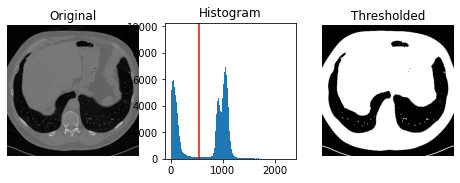

In [8]:
################################################################################################
# Part 3: Please try to use at least two different thresholding algorithm to segment the lung. #
################################################################################################

import numpy as np
import pydicom
import matplotlib.pyplot as plt
import os
from skimage.filters import threshold_local, threshold_otsu

datadir = './CT_chest_scans'

###################################################
#        Chose the thresholding algorithm!        #
#   Local mean, Local median or Otsu's method?    #
###################################################

# threshold_algorithm = 'Local_mean'
# threshold_algorithm = 'Local_median'
threshold_algorithm = 'Otsu_method'
block_size = 35 # for Local_mean and Local_median


folders = os.listdir(datadir)
for folder in folders:
    imagedir = os.path.join(datadir, folder)
    images = os.listdir(imagedir)
    data = {}
    for image in images:
        image_path = os.path.join(imagedir, image)
        pic = pydicom.dcmread(image_path)
        pix_value = pic.pixel_array
        # different threshold algorithms
        if threshold_algorithm == 'Local_mean':
            threshold = threshold_local(pix_value, block_size, 'mean') # get threshold value
            binary = pix_value > threshold # filtering using threshold value
        elif threshold_algorithm == 'Local_median':
            threshold = threshold_local(pix_value, block_size, 'median') # get threshold value
            binary = pix_value > threshold # filtering using threshold value
        elif threshold_algorithm == 'Otsu_method':
            threshold = threshold_otsu(pix_value) # get threshold value
            binary = pix_value > threshold # filtering using threshold value
        
        fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
        ax = axes.ravel()
        ax[0] = plt.subplot(1, 3, 1)
        ax[1] = plt.subplot(1, 3, 2)
        ax[2] = plt.subplot(1, 3, 3)

        ax[0].imshow(pix_value, cmap=plt.cm.gray)
        ax[0].set_title('Original')
        ax[0].axis('off')
        
        ax[1].hist(pix_value.ravel(), bins=256)
        ax[1].set_title('Histogram')
        if threshold_algorithm == 'Otsu_method':
            ax[1].axvline(threshold, color='r')
        else:
            ax[1].axvline(np.mean(threshold), color='r') # local mean and median will get an array, so I use mean value of threshold array to show on the plot.

        ax[2].imshow(binary, cmap=plt.cm.gray)
        ax[2].set_title('Thresholded')
        ax[2].axis('off')

        plt.show()

        break # comment this if you want to see more plots
    break # comment this if you want to see more plots